In [1]:
import fastf1
import pandas as pd
import matplotlib.pyplot as plt
import fastf1.plotting
import seaborn as sns

fastf1.plotting.setup_mpl(color_scheme='fastf1',misc_mpl_mods=False,mpl_timedelta_support=True)
fastf1.Cache.enable_cache('cache')
session = fastf1.get_session(2023, 'Bahrain', 'R')
session.load(telemetry=True)


laps = session.laps
df = pd.DataFrame(laps)


core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '14', '55', '44', '18', '63', '77', '10', '23', '22', '2', '20', '21', '27', '24', '4', '31', '16', '81']


In [2]:

print("DataFrame Info:")
print(df.info())


print("\nBasic Statistics:")
print(df.describe())


drivers = pd.unique(df['Driver'])
print("\nDrivers List:")
print(drivers)

fastest_laps = df.groupby('Driver')['LapTime'].min()
print("\nFastest Lap Times per Driver:")
print(fastest_laps.sort_values())

print("\nTeam Performance (Average Lap Times):")
team_stats = df.groupby('Team')['LapTime'].agg(['mean', 'median', 'min'])
print(team_stats.sort_values('mean'))


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   Time                1056 non-null   timedelta64[ns]
 1   Driver              1056 non-null   object         
 2   DriverNumber        1056 non-null   object         
 3   LapTime             1055 non-null   timedelta64[ns]
 4   LapNumber           1056 non-null   float64        
 5   Stint               1056 non-null   float64        
 6   PitOutTime          50 non-null     timedelta64[ns]
 7   PitInTime           52 non-null     timedelta64[ns]
 8   Sector1Time         1035 non-null   timedelta64[ns]
 9   Sector2Time         1055 non-null   timedelta64[ns]
 10  Sector3Time         1055 non-null   timedelta64[ns]
 11  Sector1SessionTime  1031 non-null   timedelta64[ns]
 12  Sector2SessionTime  1055 non-null   timedelta64[ns]
 13  Sector3SessionTim

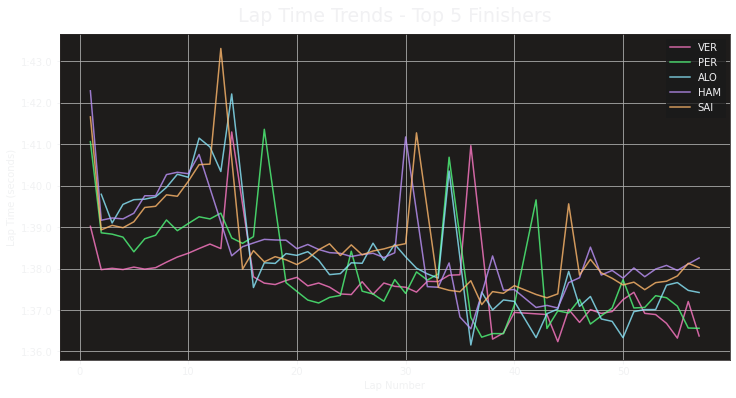

<Figure size 1080x576 with 0 Axes>

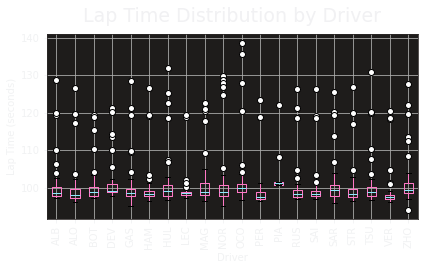

In [3]:

df['LapTime_sec'] = df['LapTime'].dt.total_seconds()

top_drivers = df[(df['LapNumber'] == 57) & (df['Position'] <= 5)]['Driver'].unique()
plt.figure(figsize=(12, 6))
for driver in top_drivers:
    driver_laps = session.laps.pick_drivers(driver).pick_quicklaps().reset_index()
    plt.plot(driver_laps['LapNumber'], driver_laps['LapTime'], label=driver, alpha =0.8)

plt.title("Lap Time Trends - Top 5 Finishers")
plt.xlabel("Lap Number")
plt.ylabel("Lap Time (seconds)")
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(15, 8))
df.boxplot(column='LapTime_sec', by='Driver', rot=90, flierprops = dict(marker='o', markerfacecolor='white', linestyle='none'))
plt.title("Lap Time Distribution by Driver")
plt.suptitle('')
plt.xlabel("Driver")
plt.ylabel("Lap Time (seconds)")
plt.tight_layout()
plt.show()

In [4]:
final_positions = df.groupby('Driver')['Position'].last().sort_values().reset_index()
driver_order = final_positions['Driver'].tolist()

c:\Users\gucie\AppData\Local\Programs\Python\Python39\lib\site-packages\fastf1\plotting\__init__.py:84: FutureWarning: INCOMPATIBLE with 2025 season! COMPOUND_COLORS is deprecated and will be removed in a future version.
  warnings.warn(f"INCOMPATIBLE with 2025 season! {name} is deprecated "


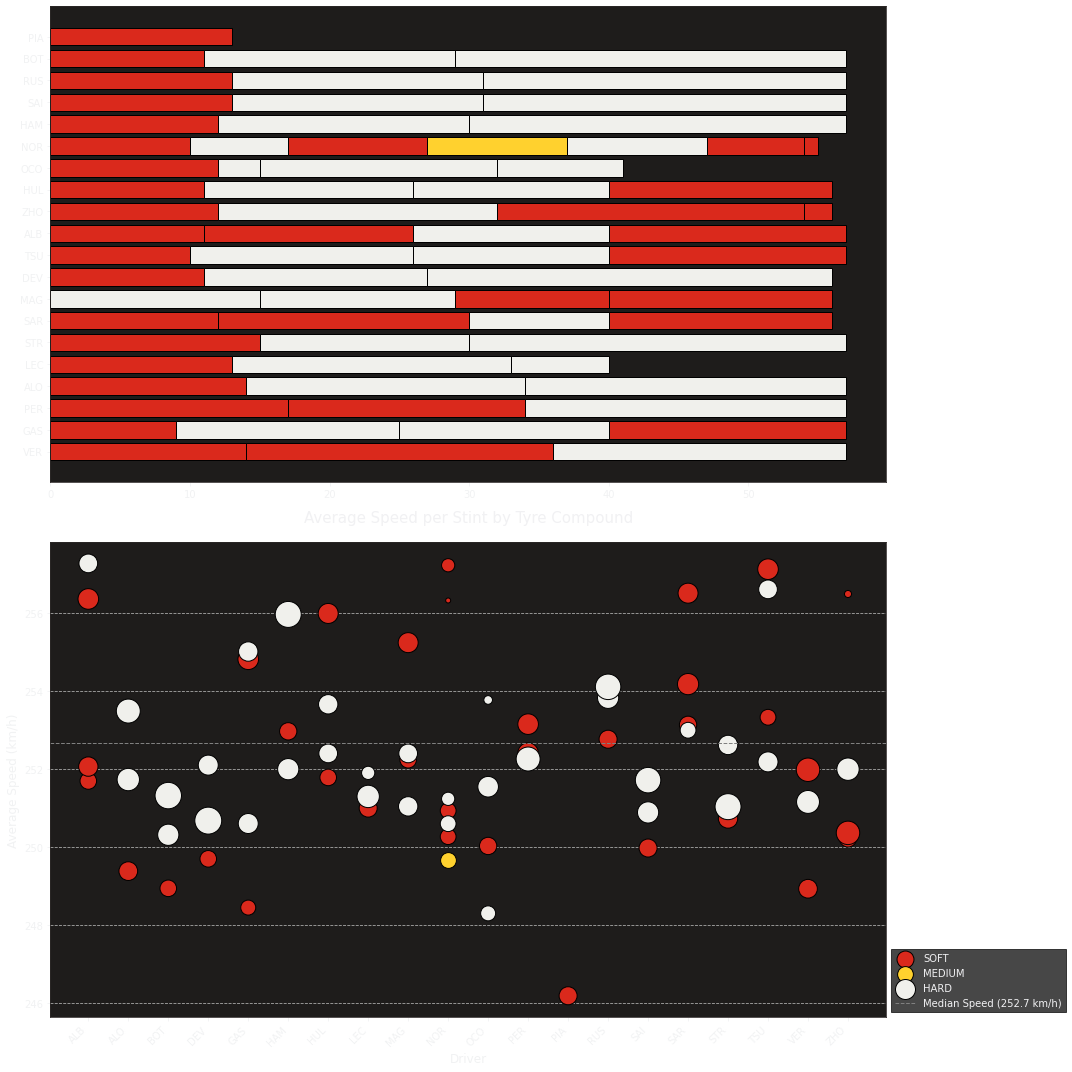


Stint Performance Summary:
Driver Compound       mean  count
   ALB     HARD 257.285714     14
   TSU     SOFT 255.235294     27
   SAR     SOFT 254.614969     46
   TSU     HARD 254.403274     30
   HAM     HARD 253.987654     45
   RUS     HARD 253.974359     44
   HUL     SOFT 253.893939     27
   MAG     SOFT 253.746212     27
   NOR     SOFT 253.692857     28
   ALB     SOFT 253.378728     43
   HUL     HARD 253.035714     29
   SAR     HARD 253.000000     10
   HAM     SOFT 252.972222     12
   GAS     HARD 252.813194     31
   PER     SOFT 252.784314     34
   RUS     SOFT 252.769231     13
   ALO     HARD 252.613043     43
   ZHO     SOFT 252.361953     36
   PER     HARD 252.260870     23
   ZHO     HARD 252.000000     20
   STR     HARD 251.829630     42
   MAG     HARD 251.724603     29
   GAS     SOFT 251.633987     26
   LEC     HARD 251.602381     27
   DEV     HARD 251.391164     45
   SAI     HARD 251.303419     44
   OCO     HARD 251.207698     29
   VER     HARD 251.

In [5]:
drivers = [session.get_driver(driver)["Abbreviation"] for driver in drivers]
stints = laps[["Driver", "Stint", "Compound", "LapNumber"]]
stints = stints.groupby(["Driver", "Stint", "Compound"])
stints = stints.count().reset_index()
stints = stints.rename(columns={"LapNumber": "StintLength"})

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15))


for driver in drivers:
    driver_stints = stints.loc[stints["Driver"] == driver]

    previous_stint_end = 0
    for idx, row in driver_stints.iterrows():
        compound_color = fastf1.plotting.get_compound_color(row["Compound"], session=session)
        ax1.barh(
            y=driver,
            width=row["StintLength"],
            left=previous_stint_end,
            color=compound_color,
            edgecolor="black",
            fill=True
        )

        previous_stint_end += row["StintLength"]


first_three = list(fastf1.plotting.COMPOUND_COLORS.items())[:3]
df['SpeedAvg'] = df[['SpeedI1', 'SpeedI2', 'SpeedFL']].ffill().mean(axis=1)
stint_data = df.groupby(['Driver', 'Stint', 'Compound'])['SpeedAvg'].agg(['mean', 'count']).reset_index()

for compound, color in first_three:
    compound_data = stint_data[stint_data['Compound'] == compound]
    ax2.scatter(
        x=compound_data['Driver'],
        y=compound_data['mean'],
        c=color,
        s=compound_data['count']*25,
        label=compound,
        edgecolors='black'
    )

ax2.set_title("Average Speed per Stint by Tyre Compound", size=15, pad=20)
ax2.set_xlabel("Driver", size=12)
ax2.set_ylabel("Average Speed (km/h)", size=12)
ax2.grid(visible=True, which='major', axis='y', linestyle='--')
ax2.legend(title="Tyre Compound", bbox_to_anchor=(1, 1), loc='upper left')


plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

median_speed = df['SpeedAvg'].median()
ax2.axhline(median_speed, color='grey', linestyle='--', linewidth=1,
            label=f'Median Speed ({median_speed:.1f} km/h)')
ax2.legend(bbox_to_anchor=(1, 0), loc='lower left')

plt.tight_layout()
plt.show()

# Additional analysis: Stint summary table
stint_summary = stint_data.groupby(['Driver', 'Compound']).agg({
    'mean': 'mean',
    'count': 'sum'
}).reset_index()

print("\nStint Performance Summary:")
print(stint_summary.sort_values(by='mean', ascending=False).to_string(index=False))

Wpływ paliwa z experckiej opinii wynosi 0.03s/kg/lap. Bolid F1 może mieć maksymalnie 110 kg paliwa, bez możliwośći tankowania podczas grand prix.  \
Każdy kierowca może startować z różną ilością paliwa, gdzie wymagane jest od 100 kg. \
Uzyskanie ilośći paliwaa i czasów pomoże nam skupić się na zachowaniu opon w późnieejszej analizie \
Dla naszych potrzeb założymy że każdy bolid startuje z minimalnym 100 kg paliwa.Aby wyliczyć zapotrzebowanie paliwa na 1 okrążenie przyjmiemy, że każdy kierowca idealnie kontroluje spalanie i kończy z 1kg paliwa pod koniec wyścigu (jeśli go ukończy)

In [6]:
results = session.results
fuel_start = 100
fuel_end = 1
fuel_penalty = 0.03

lap_length = 5.412
track_length = 308.651
laps_per_track = int(track_length / lap_length)
fuel_per_lap = (fuel_start - fuel_end) / laps_per_track
print(fuel_per_lap)

1.736842105263158


In [7]:

df['StartFuel'] = 100
def calculate_fuel(row):
    lap_number = row['LapNumber']
    if lap_number == 1:
        return row['StartFuel']
    else:
        current_fuel = max(0, row['StartFuel'] - (lap_number - 1) * fuel_per_lap)

        return current_fuel  

def calculate_avg_fuel(row):
    lap_number = row['LapNumber']
    if lap_number == 1:
        return 100
    else:
        current_fuel = df[(df['Driver'] == row['Driver']) & (df['LapNumber'] == lap_number)]['StartFuel'].values[0]
        prev_fuel = df[(df['Driver'] == row['Driver']) & (df['LapNumber'] == lap_number - 1)]['StartFuel'].values[0]
        
        avg_fuel = (current_fuel + prev_fuel) / 2

        return avg_fuel  



df['StartFuel'] = df.apply(calculate_fuel, axis=1)
df['AvgFuel'] = df.apply(calculate_avg_fuel, axis = 1)

print(df[['Driver', 'LapNumber', 'StartFuel', "AvgFuel"]])


     Driver  LapNumber   StartFuel     AvgFuel
0       VER        1.0  100.000000  100.000000
1       VER        2.0   98.263158   99.131579
2       VER        3.0   96.526316   97.394737
3       VER        4.0   94.789474   95.657895
4       VER        5.0   93.052632   93.921053
...     ...        ...         ...         ...
1051    PIA        9.0   86.105263   86.973684
1052    PIA       10.0   84.368421   85.236842
1053    PIA       11.0   82.631579   83.500000
1054    PIA       12.0   80.894737   81.763158
1055    PIA       13.0   79.157895   80.026316

[1056 rows x 4 columns]


In [8]:
def calculate_FCL(row):
    lap_time = pd.to_timedelta(row['LapTime'], unit='s')
    if pd.isnull(lap_time):
        return pd.NaT  
        
    avg_fuel = row['AvgFuel']
    fuel_correction = pd.Timedelta(seconds=0.03 * avg_fuel)
    fcl = lap_time - fuel_correction
    
    return fcl.round('ms')

In [9]:
df['FCL'] = (
    df.apply(calculate_FCL, axis=1)
)
print(df[['Driver', 'LapNumber', 'StartFuel', "AvgFuel", "LapTime", "FCL"]])

     Driver  LapNumber   StartFuel     AvgFuel                LapTime  \
0       VER        1.0  100.000000  100.000000 0 days 00:01:39.019000   
1       VER        2.0   98.263158   99.131579 0 days 00:01:37.974000   
2       VER        3.0   96.526316   97.394737 0 days 00:01:38.006000   
3       VER        4.0   94.789474   95.657895 0 days 00:01:37.976000   
4       VER        5.0   93.052632   93.921053 0 days 00:01:38.035000   
...     ...        ...         ...         ...                    ...   
1051    PIA        9.0   86.105263   86.973684 0 days 00:01:41.534000   
1052    PIA       10.0   84.368421   85.236842 0 days 00:01:41.584000   
1053    PIA       11.0   82.631579   83.500000 0 days 00:01:41.352000   
1054    PIA       12.0   80.894737   81.763158 0 days 00:01:41.156000   
1055    PIA       13.0   79.157895   80.026316 0 days 00:02:02.071000   

                        FCL  
0    0 days 00:01:36.019000  
1           0 days 00:01:35  
2    0 days 00:01:35.084000  
3  

In [10]:
driver_laps = laps.pick_drivers("VER").pick_quicklaps(1.02).reset_index()

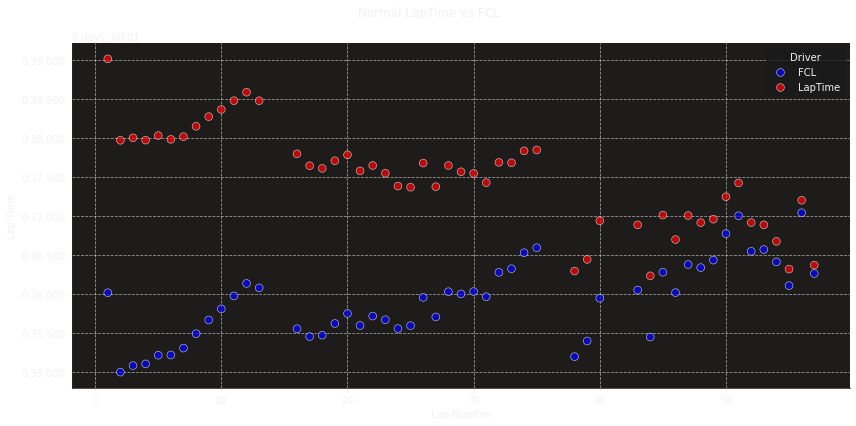

In [27]:
df['FCL_s'] = pd.to_timedelta(df['FCL']).dt.total_seconds()
df['LapTime_s'] = pd.to_timedelta(df['LapTime']).dt.total_seconds()

selected_driver = 'VER'  
df_driver = df[df['Driver'] == selected_driver]

Q1 = df_driver['LapTime_s'].quantile(0.25)
Q3 = df_driver['LapTime_s'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR  


df_clean = df_driver[df_driver['LapTime_s'] <= upper_bound]

df_long = pd.melt(df_clean, id_vars=['LapNumber'], value_vars=['FCL', 'LapTime'], var_name='Driver', value_name='LabTime')


df_long['Driver'] = df_long['Driver'].str.replace('_Seconds', '')

plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_long, x='LapNumber', y='LabTime', hue='Driver', palette=['blue', 'red'], s=60, alpha=0.7, edgecolor='w')

# plt.scatter(
#     x=df_clean['LapNumber'],
#     y=df_clean['FCL'],
#     c='blue',
#     s=60,
#     alpha=0.7,
#     edgecolor='w',
#     label="FCL"
# )


# plt.scatter(
#     x=df_clean['LapNumber'],
#     y=df_clean['LapTime'],
#     c='red',
#     s=60,
#     alpha=0.7,
#     edgecolor='w',
#     label="Normal"
# )

plt.xlabel("Lap Number")
plt.ylabel("Lap Time")
plt.gca().invert_yaxis()
plt.suptitle("Normal LapTime vs FCL")
plt.grid(
    color='lightgray', 
    linestyle='--',    
    alpha=0.7,         
    which='both',       
    axis='both'         
)
sns.despine(left=False, bottom=False) 
plt.tight_layout()
plt.show()